### Data Preprocessing - 활동별 하나의 파일로 merge

In [14]:
import numpy as np
import pandas as pd
import pytz
import os
from datetime import datetime

class ActivityDataProcessor:
    
    def __init__(self):
        self.activity_map = {
            'Open the faucet': 0,
            'Rinsing the dish': 1,
            'Put dishes on a drying rack': 2,
            'Close the faucet': 3,
            'Chopping': 4,
            'Grinding': 5,
            'Scissoring': 6,
            'Pouring': 7,
            'Stir-frying': 8,
            'Roasting': 9,
            'Turn on the stove': 10,
            'Turn off the stove': 11
        }
        self.activity_list = [
            'Open the faucet',
            'Rinsing the dish',
            'Put dishes on a drying rack',
            'Close the faucet',
            'Chopping',
            'Grinding',
            'Scissoring',
            'Pouring',
            'Stir-frying',
            'Roasting',
            'Turn on the stove',
            'Turn off the stove'
        ]

    def load_and_merge_files(self, subject_id, activity_index):
        data_types = ["AX", "AY", "AZ", "GX", "GY", "GZ"]
        
        # 카테고리 코드 계산 (0/1/2)
        if 0 <= activity_index <= 3:
            category_code = 0
        elif 4 <= activity_index <= 7:
            category_code = 1
        elif 8 <= activity_index <= 11:
            category_code = 2
        else:
            raise ValueError(f"Invalid activity index: {activity_index}")
        
        # --- Motion 파일 ---
        motion_base = os.path.join("./data", subject_id, "motion")
        dfs = []
        for data_type in data_types:
            file_path = os.path.join(motion_base, f"{subject_id}-{activity_index}_{data_type}.csv")
            df = pd.read_csv(file_path)
            df = df.drop_duplicates(subset='LocalTimestamp')
            df = df[['LocalTimestamp', data_type]].dropna()
            dfs.append(df)

        motion_df = dfs[0]
        for df in dfs[1:]:
            motion_df = pd.merge(motion_df, df, on='LocalTimestamp', how='inner')
        motion_df['LocalTimestamp'] = motion_df['LocalTimestamp'].astype(int)
        motion_df = self.detect_and_interpolate_outliers_iqr(motion_df, data_types)

        # --- Location 파일 (← 여기 핵심 수정) ---
        location_base = os.path.join("./data", subject_id, "location")
        loc_file_path = os.path.join(location_base, f"{subject_id}-{activity_index}-{category_code}.csv")
        loc_df = pd.read_csv(loc_file_path)

        time_format = "%Y/%m/%d %I:%M:%S %p"
        korea_timezone = pytz.timezone("Asia/Seoul")
        loc_df['LocalTimestamp'] = loc_df['Time'].apply(lambda x: int(korea_timezone.localize(datetime.strptime(x, time_format)).timestamp()))
        loc_df = loc_df.dropna()
        loc_df = self.detect_and_interpolate_outliers_iqr(loc_df, ['Sink', 'Countertop', 'Cooktop'])

        # Location 행 개수 맞추기
        expanded_loc_rows = []
        for timestamp in motion_df['LocalTimestamp'].unique():
            motion_count = motion_df[motion_df['LocalTimestamp'] == timestamp].shape[0]
            matching_rows = loc_df[loc_df['LocalTimestamp'] == timestamp]
            location_count = len(matching_rows)

            if location_count > motion_count:
                matching_rows = matching_rows.iloc[:motion_count]
            elif location_count < motion_count:
                last_row = matching_rows.iloc[-1:]
                while location_count < motion_count:
                    matching_rows = pd.concat([matching_rows, last_row], ignore_index=True)
                    location_count += 1

            expanded_loc_rows.append(matching_rows)

        re_loc_df = pd.concat(expanded_loc_rows).reset_index(drop=True)
        final_df = pd.concat([motion_df.reset_index(drop=True), re_loc_df[['Sink', 'Countertop', 'Cooktop']].reset_index(drop=True)], axis=1)

        if final_df.isnull().values.any():
            print(f"⚠️  누락된 값 있음: {subject_id}-{activity_index}")

        return final_df.dropna().to_numpy()

    def detect_and_interpolate_outliers_iqr(self, df, columns, k=1.5):
        df = df.copy()
        
        for col in columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - k * IQR
            upper_bound = Q3 + k * IQR
            
            outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
            
            df.loc[outliers, col] = np.nan
            
            df[col] = df[col].interpolate(method='linear')
            
            df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
        
        return df


In [19]:
import os
processor = ActivityDataProcessor()

# 피험자 파일 번호 매핑
subject_files_map = {
    'P02': [3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P03': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'P04': [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11],
    'P08': [0, 1, 2, 4, 5, 6, 7, 8, 10, 11],
    'P10': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P11': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P12': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P13': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P16': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P19': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P21': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P22': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
}

# 저장 컬럼 이름
columns = ['LocalTimestamp', 'AX', 'AY', 'AZ', 'GX', 'GY', 'GZ', 'Sink', 'Countertop', 'Cooktop']


for subject_id, activity_indices in subject_files_map.items():
    for activity_index in activity_indices:
        if 0 <= activity_index <= 3:
            category_code = 0
        elif 4 <= activity_index <= 7:
            category_code = 1
        elif 8 <= activity_index <= 11:
            category_code = 2
        else:
            print(f"❌ 잘못된 활동 번호: {activity_index}")
            continue

        try:
            data_array = processor.load_and_merge_files(
                subject_id=subject_id,
                activity_index=activity_index
            )
            
            # NumPy 배열을 DataFrame으로 변환 + 컬럼명 지정
            df = pd.DataFrame(data_array, columns=columns)

            # 저장 경로 및 파일명
            save_path = os.path.join('./data', subject_id, f"{subject_id}-{activity_index}-{category_code}-pre.csv")

            # CSV 저장
            df.to_csv(save_path, index=False)

            print(f"✅ 저장 완료: {save_path}")
            
        except Exception as e:
            print(f"❌ Error processing {subject_id}-{activity_index}: {e}")
            
            

✅ 저장 완료: ./data\P02\P02-3-0-pre.csv
✅ 저장 완료: ./data\P02\P02-4-1-pre.csv
✅ 저장 완료: ./data\P02\P02-5-1-pre.csv
✅ 저장 완료: ./data\P02\P02-6-1-pre.csv
✅ 저장 완료: ./data\P02\P02-7-1-pre.csv
✅ 저장 완료: ./data\P02\P02-8-2-pre.csv
✅ 저장 완료: ./data\P02\P02-9-2-pre.csv
✅ 저장 완료: ./data\P02\P02-10-2-pre.csv
✅ 저장 완료: ./data\P02\P02-11-2-pre.csv
⚠️  누락된 값 있음: P03-0
✅ 저장 완료: ./data\P03\P03-0-0-pre.csv
⚠️  누락된 값 있음: P03-1
✅ 저장 완료: ./data\P03\P03-1-0-pre.csv
⚠️  누락된 값 있음: P03-2
✅ 저장 완료: ./data\P03\P03-2-0-pre.csv
⚠️  누락된 값 있음: P03-3
✅ 저장 완료: ./data\P03\P03-3-0-pre.csv
⚠️  누락된 값 있음: P03-4
✅ 저장 완료: ./data\P03\P03-4-1-pre.csv
⚠️  누락된 값 있음: P03-5
✅ 저장 완료: ./data\P03\P03-5-1-pre.csv
⚠️  누락된 값 있음: P03-6
✅ 저장 완료: ./data\P03\P03-6-1-pre.csv
✅ 저장 완료: ./data\P03\P03-7-1-pre.csv
✅ 저장 완료: ./data\P03\P03-8-2-pre.csv
✅ 저장 완료: ./data\P03\P03-9-2-pre.csv
⚠️  누락된 값 있음: P04-0
✅ 저장 완료: ./data\P04\P04-0-0-pre.csv
⚠️  누락된 값 있음: P04-1
✅ 저장 완료: ./data\P04\P04-1-0-pre.csv
⚠️  누락된 값 있음: P04-2
✅ 저장 완료: ./data\P04\P04-2-0-pre.csv
⚠️  누락

In [20]:
file_path = './data/P02/P02-3-0-pre.csv'

df = pd.read_csv(file_path)
print(df.head)

<bound method NDFrame.head of       LocalTimestamp     AX     AY     AZ     GX     GY     GZ      Sink  \
0       1.721795e+09 -0.442 -0.983  0.119  1.587  1.038  0.031  0.510326   
1       1.721795e+09 -0.439 -0.996  0.127  0.488  0.671  0.366  0.510326   
2       1.721795e+09 -0.428 -1.020  0.097  0.702  2.899  0.763  0.510326   
3       1.721795e+09 -0.443 -0.985  0.117  0.061  8.392  0.977  0.510326   
4       1.721795e+09 -0.447 -0.949  0.150 -2.258  3.998  0.244  0.510326   
...              ...    ...    ...    ...    ...    ...    ...       ...   
6050    1.721796e+09 -0.512 -0.946  0.180  2.960  1.587 -1.007  0.562593   
6051    1.721796e+09 -0.511 -0.955  0.175  3.296  3.876  2.472  0.562593   
6052    1.721796e+09 -0.504 -0.965  0.183  2.106  2.838  6.287  0.563934   
6053    1.721796e+09 -0.484 -0.976  0.164  0.977  0.549  8.484  0.563934   
6054    1.721796e+09 -0.496 -0.962  0.181 -0.275  2.563  8.057  0.563934   

      Countertop   Cooktop  
0       1.638411  1.337264  

### Data Preprocessing - 하나의 파일로 저장 

In [ ]:
class ActivityDataProcessor:

    def __init__(self):
        self.activity_map = {
            'Open the faucet': 0,
            'Rinsing the dish': 1,
            'Put dishes on a drying rack': 2,
            'Close the faucet': 3,
            'Chopping': 4,
            'Grinding': 5,
            'Scissoring': 6,
            'Pouring': 7,
            'Stir-frying': 8,
            'Roasting': 9,
            'Turn on the stove': 10,
            'Turn off the stove': 11
        }
        self.activity_list = list(self.activity_map.keys())

    def create_samples(self, data, window_size=50, overlapping=50):
        step = int(window_size * (1 - overlapping / 100))
        samples = []
        for start in range(0, len(data) - window_size + 1, step):
            end = start + window_size
            samples.append(data[start:end, 1:])  # LocalTimestamp 제외
        return np.array(samples)

    def create_activity_labels(self, samples, activity):
        label = self.activity_map[activity]
        return np.full((samples.shape[0]), label)

    def combine_samples_and_labels(self, samples, labels):
        return [samples, labels]

    def process_all_files(self, subject_id, activity_indices, base_data_dir='./data', window_size=50, overlapping=50):
        activity_sensor_data = [[] for _ in range(len(self.activity_list))]

        for activity_index in activity_indices:
            # 범주 코드: 0~3 → 0, 4~7 → 1, 8~11 → 2
            if 0 <= activity_index <= 3:
                category_code = 0
            elif 4 <= activity_index <= 7:
                category_code = 1
            elif 8 <= activity_index <= 11:
                category_code = 2
            else:
                print(f"⚠️ 잘못된 활동 번호: {activity_index}")
                continue

            file_path = os.path.join(base_data_dir, subject_id, f"{subject_id}-{activity_index}-{category_code}-pre.csv")

            if not os.path.exists(file_path):
                print(f"❌ 파일 없음: {file_path}")
                continue

            data = pd.read_csv(file_path).to_numpy()
            samples = self.create_samples(data, 50, overlapping) # sampling rate 변경
            activity = self.activity_list[activity_index]
            labels = self.create_activity_labels(samples, activity)
            combined = self.combine_samples_and_labels(samples, labels)

            activity_sensor_data[activity_index].append(combined)

        return activity_sensor_data

    def merge_activity_data(self, activity_data_list):
        merged_data = []
        for activity_data in activity_data_list:
            if activity_data:
                all_samples = np.vstack([d[0] for d in activity_data])
                all_labels = np.concatenate([d[1] for d in activity_data])
                merged_data.append((all_samples, all_labels))
        return merged_data

    def check_missing_values(self, sensor_data):
        for i, (samples, labels) in enumerate(sensor_data):
            missing_samples = np.isnan(samples).sum()
            missing_labels = np.isnan(labels).sum()
            print(f"Activity {i}: missing samples = {missing_samples}, missing labels = {missing_labels}")

In [24]:
# 피험자 파일 번호 매핑
subject_files_map = {
    'P02': [3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P03': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'P04': [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11],
    'P08': [0, 1, 2, 4, 5, 6, 7, 8, 10, 11],
    'P10': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P11': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P12': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P13': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P16': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P19': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P21': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'P22': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
}

# 인스턴스 생성
processor = ActivityDataProcessor()

# 활동별 데이터 저장 리스트 (12개 활동)
activity_data_all_subjects = [[] for _ in range(len(processor.activity_list))]

# 모든 피험자 처리 루프
for subject_id, activity_indices in subject_files_map.items():
    print(f"\n📦 Processing subject: {subject_id}")
    
    # 개별 피험자 데이터 처리
    activity_data = processor.process_all_files(subject_id, activity_indices)

    # 활동별로 누적 저장
    for idx, data in enumerate(activity_data):
        if data:  # 비어있지 않으면 append
            activity_data_all_subjects[idx].extend(data)

# 병합
merged_data_all = processor.merge_activity_data(activity_data_all_subjects)

# 결측치 확인
processor.check_missing_values(merged_data_all)

# 결과 형태 출력
for i, (samples, labels) in enumerate(merged_data_all):
    print(f"[Activity {i}] ✅ Samples: {samples.shape}, Labels: {labels.shape}")


📦 Processing subject: P02

📦 Processing subject: P03

📦 Processing subject: P04

📦 Processing subject: P08

📦 Processing subject: P10

📦 Processing subject: P11

📦 Processing subject: P12

📦 Processing subject: P13

📦 Processing subject: P16

📦 Processing subject: P19

📦 Processing subject: P21

📦 Processing subject: P22
Activity 0: missing samples = 0, missing labels = 0
Activity 1: missing samples = 0, missing labels = 0
Activity 2: missing samples = 0, missing labels = 0
Activity 3: missing samples = 0, missing labels = 0
Activity 4: missing samples = 0, missing labels = 0
Activity 5: missing samples = 0, missing labels = 0
Activity 6: missing samples = 0, missing labels = 0
Activity 7: missing samples = 0, missing labels = 0
Activity 8: missing samples = 0, missing labels = 0
Activity 9: missing samples = 0, missing labels = 0
Activity 10: missing samples = 0, missing labels = 0
Activity 11: missing samples = 0, missing labels = 0
[Activity 0] ✅ Samples: (2410, 50, 9), Labels: (24

In [ ]:
sample = merged_data_all[0][0][0] # 0번 활동 -> sample data -> 그 중 0 번째 데이터 접근
label = merged_data_all[0][1][0]

# 보기 좋게 DataFrame으로 출력
df = pd.DataFrame(sample, columns=['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ', 'Sink', 'Countertop', 'Cooktop'])
df['Frame'] = range(1, len(df) + 1)
df['Label'] = label  # 전체 프레임에 동일한 라벨 부여

# 열 순서 정리
df = df[['Frame'] + list(df.columns[:-1]) + ['Label']]

print(df)


    Frame     AX     AY     AZ         GX         GY          GZ      Sink  \
0       1 -0.152 -1.047  0.189   0.183000    1.77000   -0.702000  0.618637   
1       2 -0.144 -1.057  0.190   0.183000    0.73200   -0.488000  0.618637   
2       3 -0.143 -1.052  0.187   0.366000    1.03800   -0.702000  0.618637   
3       4 -0.144 -1.050  0.193   0.031000    1.09900   -0.854000  0.618637   
4       5 -0.150 -1.056  0.193   0.031000    1.31200   -0.519000  0.615164   
5       6 -0.146 -1.060  0.189   0.732000    1.37300   -0.397000  0.615164   
6       7 -0.141 -1.042  0.197   0.580000    1.25100   -0.824000  0.615164   
7       8 -0.144 -1.053  0.191   0.305000    0.91600   -1.129000  0.615164   
8       9 -0.145 -1.050  0.193   0.214000    0.51900   -1.099000  0.615164   
9      10 -0.147 -1.058  0.190   0.275000    0.24400   -0.763000  0.615164   
10     11 -0.153 -1.051  0.189   0.458000    1.55600   -0.519000  0.615164   
11     12 -0.141 -1.052  0.196   0.519000    1.43400   -0.671000

### 전체 데이터에 대한 수 Plot

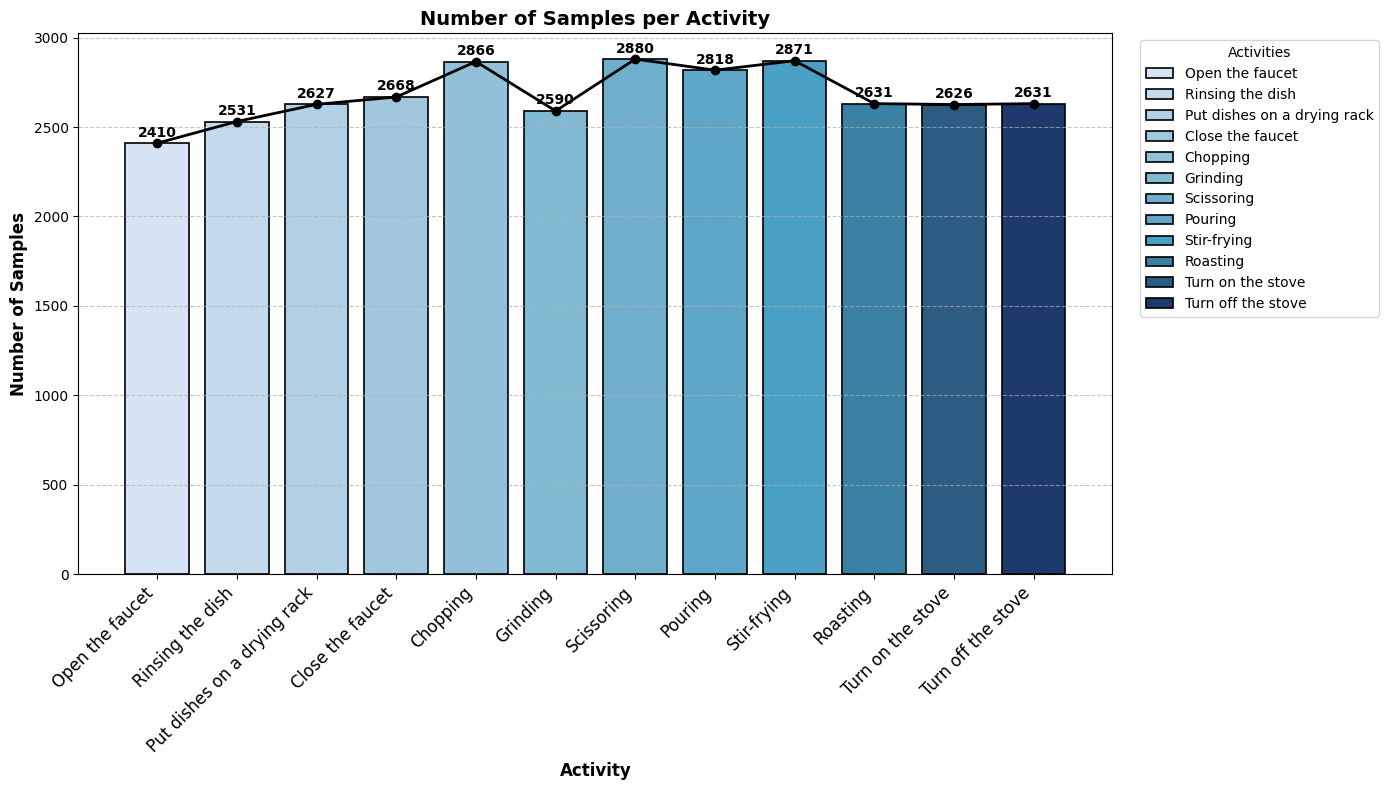

In [33]:
import matplotlib.pyplot as plt

# 사용자 정의 색상 팔레트 (12단계)
custom_user_colors = [
    (214/255, 228/255, 245/255),
    (196/255, 218/255, 237/255),
    (178/255, 208/255, 229/255),
    (161/255, 199/255, 221/255),
    (146/255, 192/255, 216/255),
    (129/255, 185/255, 210/255),
    (112/255, 175/255, 204/255),
    (95/255, 167/255, 200/255),
    (74/255, 160/255, 196/255),
    (58/255, 129/255, 164/255),
    (45/255, 92/255, 130/255),
    (29/255, 58/255, 109/255)
]

# 활동 이름 (X축 레이블)
activity_list = [
    'Open the faucet',
            'Rinsing the dish',
            'Put dishes on a drying rack',
            'Close the faucet',
            'Chopping',
            'Grinding',
            'Scissoring',
            'Pouring',
            'Stir-frying',
            'Roasting',
            'Turn on the stove',
            'Turn off the stove'
]

# 실제 활동별 샘플 수 추출
data_counts = [merged_data_all[i][0].shape[0] for i in range(len(activity_list))]

# 그래프 그리기
plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(activity_list)), data_counts, color=custom_user_colors, edgecolor='black', linewidth=1.2)

# 막대 위에 숫자 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 20, int(yval),
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# 선 그래프 덧씌우기
plt.plot(range(len(activity_list)), data_counts, marker='o', color='black', linestyle='-', linewidth=2, markersize=6)

# 라벨/타이틀 등 설정
plt.xlabel('Activity', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Number of Samples per Activity', fontsize=14, fontweight='bold')
plt.xticks(range(len(activity_list)), activity_list, rotation=45, fontsize=12, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
plt.legend(bars, activity_list, title="Activities", fontsize=10, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

### Data Preprocessing - Train/Test Split (7:3)

In [38]:
from sklearn.model_selection import train_test_split
import numpy as np

# 1. 전체 샘플과 라벨을 하나로 합치기
all_samples = np.vstack([samples for samples, _ in merged_data_all])
all_labels = np.concatenate([labels for _, labels in merged_data_all])

print("전체 샘플 shape:", all_samples.shape)  # (N, 50, 9)
print("전체 라벨 shape:", all_labels.shape)  # (N,)

# 2. Train/Test 분할 (stratify로 클래스 비율 유지)
X_train, X_test, y_act_train, y_act_test = train_test_split(
    all_samples, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

# 3. 결과 출력
print("✅ X_train:", X_train.shape)
print("✅ X_test :", X_test.shape)
print("✅ y_act_train:", y_act_train.shape)
print("✅ y_act_test :", y_act_test.shape)


# NaN 확인
print("🔍 X_train contains NaN:", np.isnan(X_train).any())
print("🔍 X_test  contains NaN:", np.isnan(X_test).any())

전체 샘플 shape: (32149, 50, 9)
전체 라벨 shape: (32149,)
✅ X_train: (22504, 50, 9)
✅ X_test : (9645, 50, 9)
✅ y_act_train: (22504,)
✅ y_act_test : (9645,)
🔍 X_train contains NaN: False
🔍 X_test  contains NaN: False


In [39]:
for i in range(10):
    print(X_train[i][0])
    print(y_act_train[i])
    print('------------------------')

[ -0.844       -0.223        0.419       69.397      109.848
  16.449        0.701572     1.76275313   1.30431974]
2
------------------------
[ -0.682       -0.49        -0.544      -13.031       -8.026
  -7.812        0.97058117   2.95098996   0.51867974]
9
------------------------
[ -0.58        -0.955        0.269       21.545      134.003
  45.685        1.05876741   3.01954317   0.67996152]
10
------------------------
[-5.92000000e-01  1.39000000e-01  5.09000000e-01  4.13313333e+01
  4.47080000e+01  1.87890800e+02  5.20327151e-01  1.87292540e+00
  1.21782076e+00]
0
------------------------
[-0.165      -0.631       0.882      20.844      78.85777778 -8.087
  1.29766715  3.16947556  0.60785913]
9
------------------------
[-0.379      -0.98        0.45       25.97       90.942      10.254
  0.91948974  2.43969989  0.61567026]
10
------------------------
[ -0.713       -0.275        0.278       29.144       37.598
 139.832        0.51063728   2.54295826   1.50066924]
2
--------------

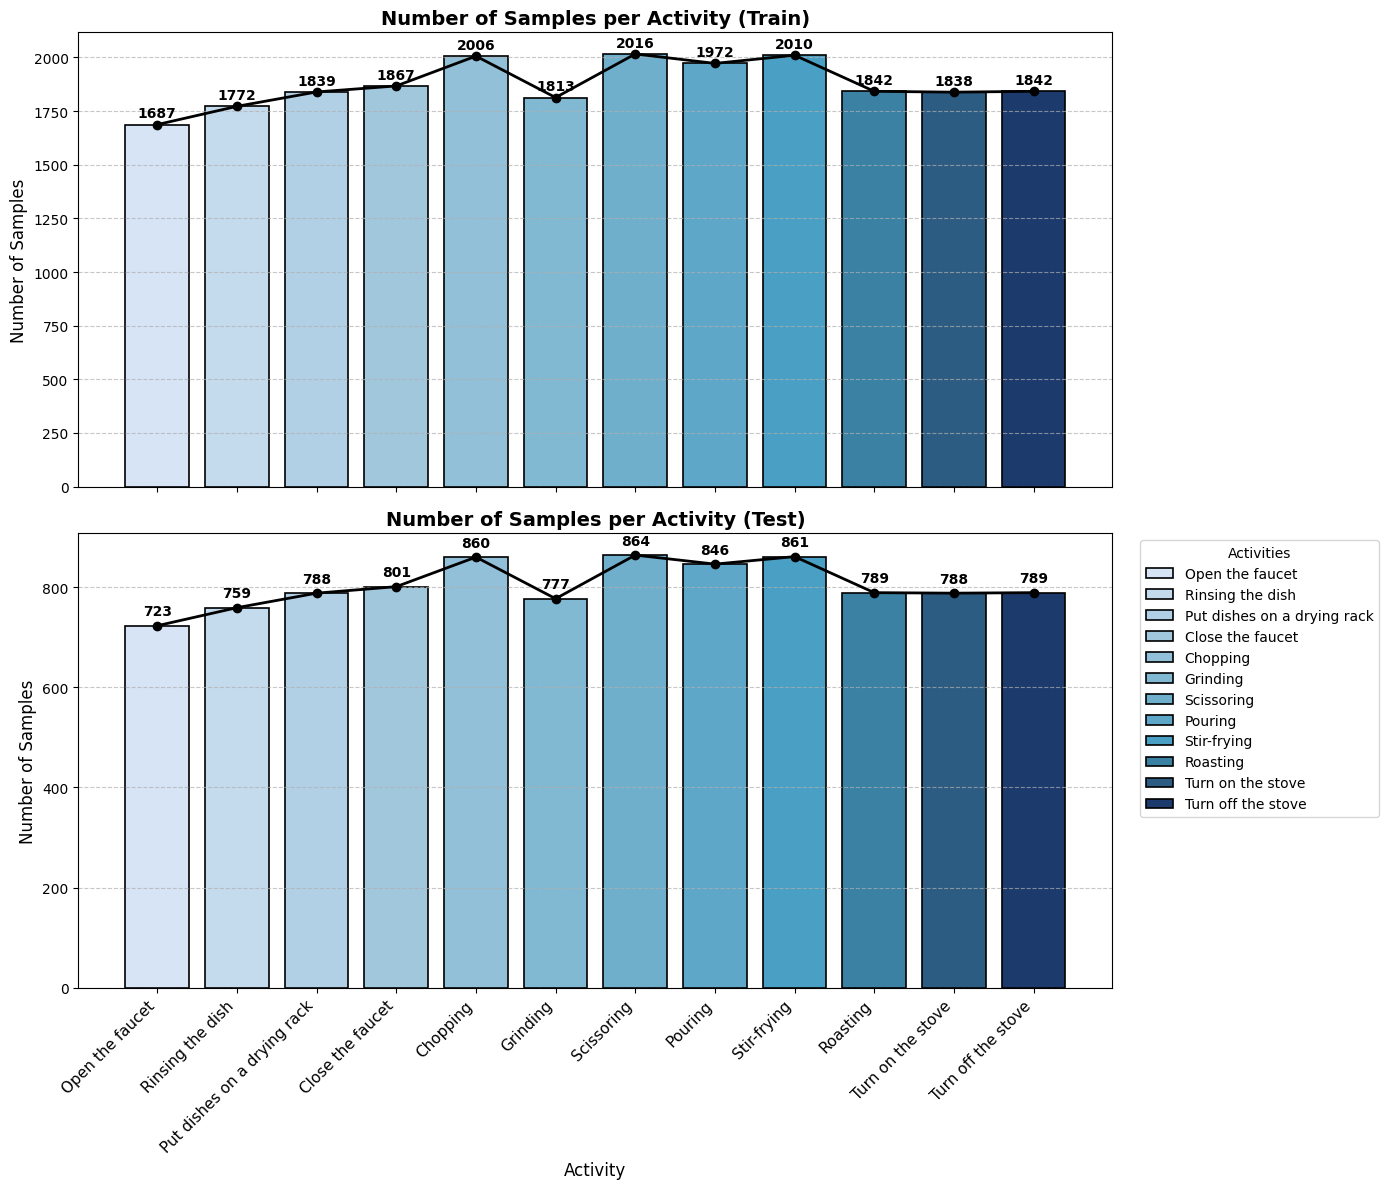

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# 활동 이름
activity_list = [
    'Open the faucet',
    'Rinsing the dish',
    'Put dishes on a drying rack',
    'Close the faucet',
    'Chopping',
    'Grinding',
    'Scissoring',
    'Pouring',
    'Stir-frying',
    'Roasting',
    'Turn on the stove',
    'Turn off the stove'
]

# 사용자 정의 색상
custom_user_colors = [
    (214/255, 228/255, 245/255),
    (196/255, 218/255, 237/255),
    (178/255, 208/255, 229/255),
    (161/255, 199/255, 221/255),
    (146/255, 192/255, 216/255),
    (129/255, 185/255, 210/255),
    (112/255, 175/255, 204/255),
    (95/255, 167/255, 200/255),
    (74/255, 160/255, 196/255),
    (58/255, 129/255, 164/255),
    (45/255, 92/255, 130/255),
    (29/255, 58/255, 109/255)
]

# Train/Test 분할된 데이터에서 샘플 수 계산
train_counts = [np.sum(y_act_train == i) for i in range(len(activity_list))]
test_counts = [np.sum(y_act_test == i) for i in range(len(activity_list))]

# 시각화
fig, ax = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# --- Train ---
bars_train = ax[0].bar(range(len(activity_list)), train_counts, color=custom_user_colors, edgecolor='black', linewidth=1.2)
for bar in bars_train:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width() / 2, yval + 20, int(yval),
               ha='center', va='bottom', fontsize=10, fontweight='bold')
ax[0].plot(range(len(activity_list)), train_counts, marker='o', color='black', linewidth=2)
ax[0].set_title('Number of Samples per Activity (Train)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Number of Samples', fontsize=12)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- Test ---
bars_test = ax[1].bar(range(len(activity_list)), test_counts, color=custom_user_colors, edgecolor='black', linewidth=1.2)
for bar in bars_test:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width() / 2, yval + 15, int(yval),
               ha='center', va='bottom', fontsize=10, fontweight='bold')
ax[1].plot(range(len(activity_list)), test_counts, marker='o', color='black', linewidth=2)
ax[1].set_title('Number of Samples per Activity (Test)', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Number of Samples', fontsize=12)
ax[1].set_xlabel('Activity', fontsize=12)
ax[1].set_xticks(range(len(activity_list)))
ax[1].set_xticklabels(activity_list, rotation=45, ha='right', fontsize=11)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
ax[1].legend(bars_test, activity_list, title="Activities", fontsize=10, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()


### 데이터 pre_data 폴더에 저장 -> 다시 불러올 때는 x_train_flat.reshape(50,9)

In [40]:
# 저장 폴더 생성
os.makedirs('./pre_data/within', exist_ok=True)

# reshape: (N, 50, 9) → (N, 450)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 저장
pd.DataFrame(X_train_flat).to_csv('./pre_data//within/X_train.csv', index=False)
pd.DataFrame(y_act_train).to_csv('./pre_data/within/y_act_train.csv', index=False, header=['label'])

pd.DataFrame(X_test_flat).to_csv('./pre_data/within/X_test.csv', index=False)
pd.DataFrame(y_act_test).to_csv('./pre_data/within/y_act_test.csv', index=False, header=['label'])

print("✅ 데이터 저장 완료!")

✅ 데이터 저장 완료!


### 저장한 데이터 불러오기 

In [42]:
# CSV 불러오기
X_train_flat = pd.read_csv('./pre_data//within/X_train.csv').to_numpy()       # shape: (N, 450)
y_train = pd.read_csv('./pre_data/within/y_act_train.csv').to_numpy().flatten()  # shape: (N,) → flatten()으로 1D로 변환

# reshape to original shape (N, 50, 9)
X_train = X_train_flat.reshape(-1, 50, 9)

# 결과 확인
print("X_train shape:", X_train.shape)  # (N, 50, 9)
print("y_train shape:", y_train.shape)  # (N,)

X_train shape: (22504, 50, 9)
y_train shape: (22504,)


### Same location data 변경

In [45]:
# 복사본 생성
X_nogry_train = X_train.copy()
X_nogry_test = X_test.copy()

# 마지막 3개 피처 (axis=2 기준: -3, -2, -1)에 대해 0으로 설정
X_nogry_train[:, :, -3:] = 0
X_nogry_test[:, :, -3:] = 0

# 결과 확인
print("✅ X_nogry_train shape:", X_nogry_train.shape)
print("✅ X_nogry_test  shape:", X_nogry_test.shape)
print("예시 확인 (첫 샘플 마지막 피처):\n", X_nogry_train[0, -1])

✅ X_nogry_train shape: (22504, 50, 9)
✅ X_nogry_test  shape: (9645, 50, 9)
예시 확인 (첫 샘플 마지막 피처):
 [-0.232 -1.006  0.309  3.387 -6.256 11.963  0.     0.     0.   ]


### Same location data 저장

In [ ]:
# 저장 폴더 생성
os.makedirs('./pre_data/within', exist_ok=True)

# reshape: (N, 50, 9) → (N, 450)
X_nogry_train_flat = X_nogry_train.reshape(X_nogry_train.shape[0], -1)
X_nogry_test_flat = X_nogry_test.reshape(X_nogry_test.shape[0], -1)

# 저장
pd.DataFrame(X_nogry_train_flat).to_csv('./pre_data//within/X_nogry_train.csv', index=False)
pd.DataFrame(X_nogry_test_flat).to_csv('./pre_data/within/X_nogry_test.csv', index=False)

print("✅ 데이터 저장 완료!")

✅ 데이터 저장 완료!


### Model Training - Different Location

### 1. LSTM

In [117]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# 🔒 재현성 고정
np.random.seed(42)
tf.random.set_seed(42)

# 클래스 수
num_classes = 12

# 평가 결과 저장 리스트
lstm1_acc_list = []
lstm1_prec_list = []
lstm1_recall_list = []
lstm1_f1_list = []
lstm1_cm_sum = np.zeros((num_classes, num_classes), dtype=int)

# EarlyStopping 정의
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=0
)

# 🔁 LSTM 모델 100회 반복 학습
for i in range(100):
    lstm1 = Sequential()
    lstm1.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    lstm1.add(Dropout(0.3))
    lstm1.add(LSTM(64))
    lstm1.add(Dropout(0.3))
    lstm1.add(Dense(32, activation='relu'))
    lstm1.add(Dense(num_classes, activation='softmax'))

    lstm1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    lstm1.fit(X_train, y_act_train,
              epochs=50,
              batch_size=64,
              validation_split=0.2,
              callbacks=[early_stop],
              verbose=0)

    # 예측 및 지표 계산
    y_pred_lstm1 = np.argmax(lstm1.predict(X_test, verbose=0), axis=1)

    lstm1_acc_list.append(accuracy_score(y_act_test, y_pred_lstm1))
    lstm1_prec_list.append(precision_score(y_act_test, y_pred_lstm1, average='macro', zero_division=0))
    lstm1_recall_list.append(recall_score(y_act_test, y_pred_lstm1, average='macro', zero_division=0))
    lstm1_f1_list.append(f1_score(y_act_test, y_pred_lstm1, average='macro', zero_division=0))

    lstm1_cm_sum += confusion_matrix(y_act_test, y_pred_lstm1)

print("✅ LSTM 100회 학습 완료!")


✅ LSTM 100회 학습 완료!


In [118]:
print("📊 Accuracy : {:.4f} ± {:.4f}".format(np.mean(lstm1_acc_list), np.std(lstm1_acc_list)))
print("📊 Precision: {:.4f} ± {:.4f}".format(np.mean(lstm1_prec_list), np.std(lstm1_prec_list)))
print("📊 Recall   : {:.4f} ± {:.4f}".format(np.mean(lstm1_recall_list), np.std(lstm1_recall_list)))
print("📊 F1-score : {:.4f} ± {:.4f}".format(np.mean(lstm1_f1_list), np.std(lstm1_f1_list)))

📊 Accuracy : 0.9805 ± 0.0027
📊 Precision: 0.9808 ± 0.0027
📊 Recall   : 0.9805 ± 0.0028
📊 F1-score : 0.9806 ± 0.0027


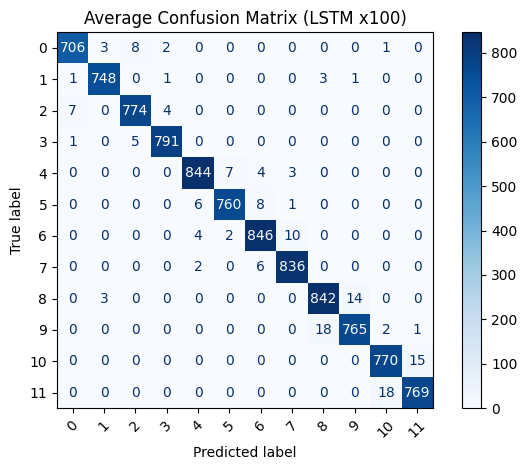

In [119]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

lstm1_cm_avg = lstm1_cm_sum // 100
disp = ConfusionMatrixDisplay(confusion_matrix=lstm1_cm_avg)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Average Confusion Matrix (LSTM x100)")
plt.tight_layout()
plt.show()


### 2. GRU

In [120]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

# 클래스 수
num_classes = 12

# 결과 저장 리스트 초기화
gru1_acc_list = []
gru1_prec_list = []
gru1_recall_list = []
gru1_f1_list = []
gru1_cm_sum = np.zeros((num_classes, num_classes), dtype=int)

# EarlyStopping 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=0
)

# 🔁 GRU 100회 반복 학습
for i in range(100):
    gru1 = Sequential()
    gru1.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    gru1.add(Dropout(0.3))
    gru1.add(GRU(64))
    gru1.add(Dropout(0.3))
    gru1.add(Dense(32, activation='relu'))
    gru1.add(Dense(num_classes, activation='softmax'))

    gru1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    gru1.fit(X_train, y_act_train,
             epochs=50,
             batch_size=64,
             validation_split=0.2,
             callbacks=[early_stop],
             verbose=0)

    # 예측 및 평가
    y_pred_gru1 = np.argmax(gru1.predict(X_test, verbose=0), axis=1)

    gru1_acc_list.append(accuracy_score(y_act_test, y_pred_gru1))
    gru1_prec_list.append(precision_score(y_act_test, y_pred_gru1, average='macro', zero_division=0))
    gru1_recall_list.append(recall_score(y_act_test, y_pred_gru1, average='macro', zero_division=0))
    gru1_f1_list.append(f1_score(y_act_test, y_pred_gru1, average='macro', zero_division=0))

    # confusion matrix 누적
    gru1_cm_sum += confusion_matrix(y_act_test, y_pred_gru1)

print("✅ GRU 모델 100회 학습 완료!")

✅ GRU 모델 100회 학습 완료!


📊 GRU Accuracy : 0.9824 ± 0.0022
📊 GRU Precision: 0.9826 ± 0.0021
📊 GRU Recall   : 0.9824 ± 0.0022
📊 GRU F1-score : 0.9824 ± 0.0022


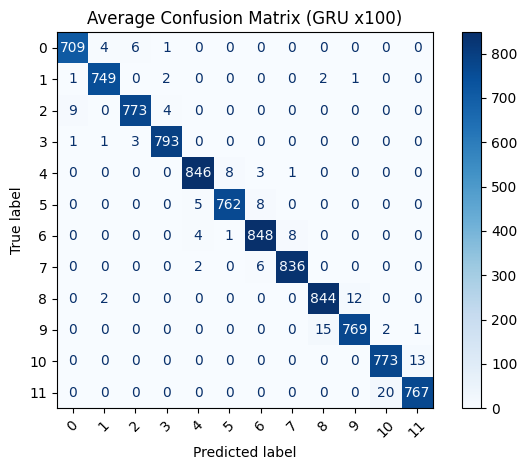

In [134]:
# 평균 지표 출력
print("📊 GRU Accuracy : {:.4f} ± {:.4f}".format(np.mean(gru1_acc_list), np.std(gru1_acc_list)))
print("📊 GRU Precision: {:.4f} ± {:.4f}".format(np.mean(gru1_prec_list), np.std(gru1_prec_list)))
print("📊 GRU Recall   : {:.4f} ± {:.4f}".format(np.mean(gru1_recall_list), np.std(gru1_recall_list)))
print("📊 GRU F1-score : {:.4f} ± {:.4f}".format(np.mean(gru1_f1_list), np.std(gru1_f1_list)))

# 평균 confusion matrix 시각화
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

gru1_cm_avg = gru1_cm_sum // 100
ConfusionMatrixDisplay(confusion_matrix=gru1_cm_avg).plot(cmap='Blues', xticks_rotation=45)
plt.title("Average Confusion Matrix (GRU x100)")
plt.tight_layout()
plt.show()

### 3. Bi-LSTM

In [122]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

# 클래스 수
num_classes = 12

# 결과 저장 리스트
bilstm1_acc_list = []
bilstm1_prec_list = []
bilstm1_recall_list = []
bilstm1_f1_list = []
bilstm1_cm_sum = np.zeros((num_classes, num_classes), dtype=int)

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=0
)

# 🔁 100회 반복 학습
for i in range(100):
    bilstm1 = Sequential()
    bilstm1.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    # bilstm1.add(Dropout(0.3))
    bilstm1.add(Bidirectional(LSTM(64)))
    # bilstm1.add(Dropout(0.3))
    bilstm1.add(Dense(32, activation='relu'))
    bilstm1.add(Dense(num_classes, activation='softmax'))

    bilstm1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    bilstm1.fit(X_train, y_act_train,
                epochs=50,
                batch_size=64,
                validation_split=0.2,
                callbacks=[early_stop],
                verbose=0)

    y_pred_bilstm1 = np.argmax(bilstm1.predict(X_test, verbose=0), axis=1)

    bilstm1_acc_list.append(accuracy_score(y_act_test, y_pred_bilstm1))
    bilstm1_prec_list.append(precision_score(y_act_test, y_pred_bilstm1, average='macro', zero_division=0))
    bilstm1_recall_list.append(recall_score(y_act_test, y_pred_bilstm1, average='macro', zero_division=0))
    bilstm1_f1_list.append(f1_score(y_act_test, y_pred_bilstm1, average='macro', zero_division=0))

    bilstm1_cm_sum += confusion_matrix(y_act_test, y_pred_bilstm1)

print("✅ Bidirectional LSTM 모델 100회 학습 완료!")


✅ Bidirectional LSTM 모델 100회 학습 완료!


📊 BiLSTM Accuracy : 0.9818 ± 0.0027
📊 BiLSTM Precision: 0.9820 ± 0.0026
📊 BiLSTM Recall   : 0.9818 ± 0.0027
📊 BiLSTM F1-score : 0.9818 ± 0.0027


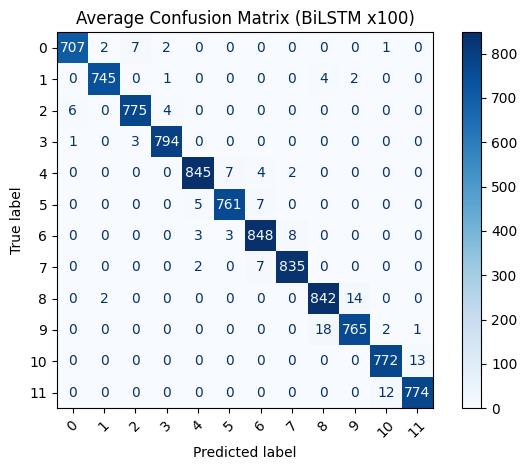

In [123]:
# 평균 + 표준편차 출력
print("📊 BiLSTM Accuracy : {:.4f} ± {:.4f}".format(np.mean(bilstm1_acc_list), np.std(bilstm1_acc_list)))
print("📊 BiLSTM Precision: {:.4f} ± {:.4f}".format(np.mean(bilstm1_prec_list), np.std(bilstm1_prec_list)))
print("📊 BiLSTM Recall   : {:.4f} ± {:.4f}".format(np.mean(bilstm1_recall_list), np.std(bilstm1_recall_list)))
print("📊 BiLSTM F1-score : {:.4f} ± {:.4f}".format(np.mean(bilstm1_f1_list), np.std(bilstm1_f1_list)))

# 평균 confusion matrix 시각화
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

bilstm1_cm_avg = bilstm1_cm_sum // 100
ConfusionMatrixDisplay(confusion_matrix=bilstm1_cm_avg).plot(cmap='Blues', xticks_rotation=45)
plt.title("Average Confusion Matrix (BiLSTM x100)")
plt.tight_layout()
plt.show()


### 4. Bi-GRU

In [124]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

# 클래스 수
num_classes = 12

# 결과 저장 리스트 초기화
bigru1_acc_list = []
bigru1_prec_list = []
bigru1_recall_list = []
bigru1_f1_list = []
bigru1_cm_sum = np.zeros((num_classes, num_classes), dtype=int)

# EarlyStopping 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=0
)

# 🔁 Bidirectional GRU 100회 반복 학습
for i in range(100):
    bigru1 = Sequential()
    bigru1.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    bigru1.add(Dropout(0.3))
    bigru1.add(Bidirectional(GRU(64)))
    bigru1.add(Dropout(0.3))
    bigru1.add(Dense(32, activation='relu'))
    bigru1.add(Dense(num_classes, activation='softmax'))

    bigru1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    bigru1.fit(X_train, y_act_train,
               epochs=50,
               batch_size=64,
               validation_split=0.2,
               callbacks=[early_stop],
               verbose=0)

    y_pred_bigru1 = np.argmax(bigru1.predict(X_test, verbose=0), axis=1)

    bigru1_acc_list.append(accuracy_score(y_act_test, y_pred_bigru1))
    bigru1_prec_list.append(precision_score(y_act_test, y_pred_bigru1, average='macro', zero_division=0))
    bigru1_recall_list.append(recall_score(y_act_test, y_pred_bigru1, average='macro', zero_division=0))
    bigru1_f1_list.append(f1_score(y_act_test, y_pred_bigru1, average='macro', zero_division=0))

    bigru1_cm_sum += confusion_matrix(y_act_test, y_pred_bigru1)

print("✅ Bidirectional GRU 모델 100회 학습 완료!")

✅ Bidirectional GRU 모델 100회 학습 완료!


📊 BiGRU Accuracy : 0.9848 ± 0.0020
📊 BiGRU Precision: 0.9850 ± 0.0019
📊 BiGRU Recall   : 0.9848 ± 0.0020
📊 BiGRU F1-score : 0.9848 ± 0.0020


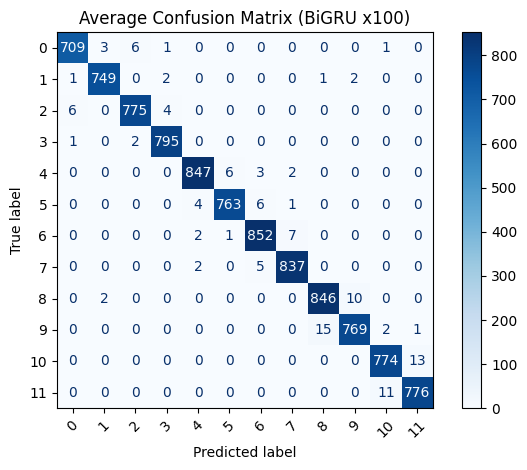

In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 평균 및 표준편차
print("📊 BiGRU Accuracy : {:.4f} ± {:.4f}".format(np.mean(bigru1_acc_list), np.std(bigru1_acc_list)))
print("📊 BiGRU Precision: {:.4f} ± {:.4f}".format(np.mean(bigru1_prec_list), np.std(bigru1_prec_list)))
print("📊 BiGRU Recall   : {:.4f} ± {:.4f}".format(np.mean(bigru1_recall_list), np.std(bigru1_recall_list)))
print("📊 BiGRU F1-score : {:.4f} ± {:.4f}".format(np.mean(bigru1_f1_list), np.std(bigru1_f1_list)))

# 평균 confusion matrix 시각화
bigru1_cm_avg = bigru1_cm_sum // 100
ConfusionMatrixDisplay(confusion_matrix=bigru1_cm_avg).plot(cmap='Blues', xticks_rotation=45)
plt.title("Average Confusion Matrix (BiGRU x100)")
plt.tight_layout()
plt.show()

### Model Training - Same Location

### 1. LSTM

In [126]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

# 클래스 수
num_classes = 12

# 결과 저장 리스트 초기화
lstm2_acc_list = []
lstm2_prec_list = []
lstm2_recall_list = []
lstm2_f1_list = []
lstm2_cm_sum = np.zeros((num_classes, num_classes), dtype=int)

# EarlyStopping 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=0
)

# 🔁 LSTM2 100회 반복 학습 (X_nogry_train 사용)
for i in range(100):
    lstm2 = Sequential()
    lstm2.add(LSTM(128, input_shape=(X_nogry_train.shape[1], X_nogry_train.shape[2]), return_sequences=True))
    lstm2.add(Dropout(0.3))
    lstm2.add(LSTM(64))
    lstm2.add(Dropout(0.3))
    lstm2.add(Dense(32, activation='relu'))
    lstm2.add(Dense(num_classes, activation='softmax'))

    lstm2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    lstm2.fit(X_nogry_train, y_act_train,
              epochs=50,
              batch_size=64,
              validation_split=0.2,
              callbacks=[early_stop],
              verbose=0)

    y_pred_lstm2 = np.argmax(lstm2.predict(X_nogry_test, verbose=0), axis=1)

    lstm2_acc_list.append(accuracy_score(y_act_test, y_pred_lstm2))
    lstm2_prec_list.append(precision_score(y_act_test, y_pred_lstm2, average='macro', zero_division=0))
    lstm2_recall_list.append(recall_score(y_act_test, y_pred_lstm2, average='macro', zero_division=0))
    lstm2_f1_list.append(f1_score(y_act_test, y_pred_lstm2, average='macro', zero_division=0))

    lstm2_cm_sum += confusion_matrix(y_act_test, y_pred_lstm2)

print("✅ LSTM2 모델 100회 학습 완료 (X_nogry 기반)")

✅ LSTM2 모델 100회 학습 완료 (X_nogry 기반)


📊 LSTM2 Accuracy : 0.9669 ± 0.0040
📊 LSTM2 Precision: 0.9674 ± 0.0039
📊 LSTM2 Recall   : 0.9669 ± 0.0040
📊 LSTM2 F1-score : 0.9670 ± 0.0040


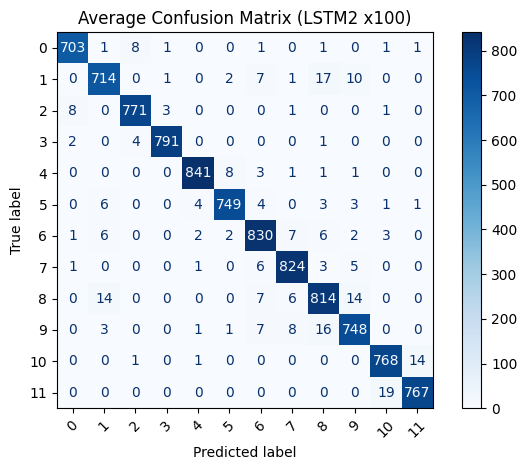

In [127]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 📊 평균 + 표준편차 출력
print("📊 LSTM2 Accuracy : {:.4f} ± {:.4f}".format(np.mean(lstm2_acc_list), np.std(lstm2_acc_list)))
print("📊 LSTM2 Precision: {:.4f} ± {:.4f}".format(np.mean(lstm2_prec_list), np.std(lstm2_prec_list)))
print("📊 LSTM2 Recall   : {:.4f} ± {:.4f}".format(np.mean(lstm2_recall_list), np.std(lstm2_recall_list)))
print("📊 LSTM2 F1-score : {:.4f} ± {:.4f}".format(np.mean(lstm2_f1_list), np.std(lstm2_f1_list)))

# 📈 평균 Confusion Matrix 시각화
lstm2_cm_avg = lstm2_cm_sum // 100

disp = ConfusionMatrixDisplay(confusion_matrix=lstm2_cm_avg)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Average Confusion Matrix (LSTM2 x100)")
plt.tight_layout()
plt.show()

### 2. GRU

In [128]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

# 클래스 수
num_classes = 12

# 결과 저장 리스트 초기화
gru2_acc_list = []
gru2_prec_list = []
gru2_recall_list = []
gru2_f1_list = []
gru2_cm_sum = np.zeros((num_classes, num_classes), dtype=int)

# EarlyStopping 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=0
)

# 🔁 GRU2 100회 반복 학습
for i in range(100):
    gru2 = Sequential()
    gru2.add(GRU(128, input_shape=(X_nogry_train.shape[1], X_nogry_train.shape[2]), return_sequences=True))
    gru2.add(Dropout(0.3))
    gru2.add(GRU(64))
    gru2.add(Dropout(0.3))
    gru2.add(Dense(32, activation='relu'))
    gru2.add(Dense(num_classes, activation='softmax'))

    gru2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    gru2.fit(X_nogry_train, y_act_train,
             epochs=50,
             batch_size=64,
             validation_split=0.2,
             callbacks=[early_stop],
             verbose=0)

    y_pred_gru2 = np.argmax(gru2.predict(X_nogry_test, verbose=0), axis=1)

    gru2_acc_list.append(accuracy_score(y_act_test, y_pred_gru2))
    gru2_prec_list.append(precision_score(y_act_test, y_pred_gru2, average='macro', zero_division=0))
    gru2_recall_list.append(recall_score(y_act_test, y_pred_gru2, average='macro', zero_division=0))
    gru2_f1_list.append(f1_score(y_act_test, y_pred_gru2, average='macro', zero_division=0))

    gru2_cm_sum += confusion_matrix(y_act_test, y_pred_gru2)

print("✅ GRU2 모델 100회 학습 완료 (X_nogry 기반)")

✅ GRU2 모델 100회 학습 완료 (X_nogry 기반)


📊 GRU2 Accuracy : 0.9687 ± 0.0032
📊 GRU2 Precision: 0.9692 ± 0.0031
📊 GRU2 Recall   : 0.9687 ± 0.0032
📊 GRU2 F1-score : 0.9689 ± 0.0032


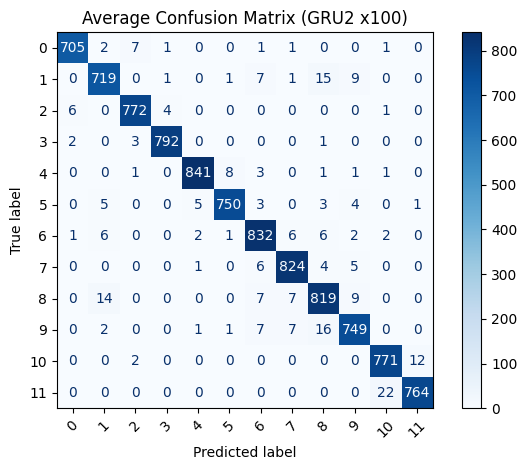

In [129]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 평균 및 표준편차 출력
print("📊 GRU2 Accuracy : {:.4f} ± {:.4f}".format(np.mean(gru2_acc_list), np.std(gru2_acc_list)))
print("📊 GRU2 Precision: {:.4f} ± {:.4f}".format(np.mean(gru2_prec_list), np.std(gru2_prec_list)))
print("📊 GRU2 Recall   : {:.4f} ± {:.4f}".format(np.mean(gru2_recall_list), np.std(gru2_recall_list)))
print("📊 GRU2 F1-score : {:.4f} ± {:.4f}".format(np.mean(gru2_f1_list), np.std(gru2_f1_list)))

# Confusion Matrix 시각화
gru2_cm_avg = gru2_cm_sum // 100
ConfusionMatrixDisplay(confusion_matrix=gru2_cm_avg).plot(cmap='Blues', xticks_rotation=45)
plt.title("Average Confusion Matrix (GRU2 x100)")
plt.tight_layout()
plt.show()


### Bi-LSTM

In [130]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

# 클래스 수
num_classes = 12

# 결과 저장 리스트 초기화
bilstm2_acc_list = []
bilstm2_prec_list = []
bilstm2_recall_list = []
bilstm2_f1_list = []
bilstm2_cm_sum = np.zeros((num_classes, num_classes), dtype=int)

# EarlyStopping 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=0
)

# 🔁 BiLSTM2 100회 반복 학습 (X_nogry 기반)
for i in range(100):
    bilstm2 = Sequential()
    bilstm2.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_nogry_train.shape[1], X_nogry_train.shape[2])))
    bilstm2.add(Dropout(0.3))
    bilstm2.add(Bidirectional(LSTM(64)))
    bilstm2.add(Dropout(0.3))
    bilstm2.add(Dense(32, activation='relu'))
    bilstm2.add(Dense(num_classes, activation='softmax'))

    bilstm2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    bilstm2.fit(X_nogry_train, y_act_train,
                epochs=50,
                batch_size=64,
                validation_split=0.2,
                callbacks=[early_stop],
                verbose=0)

    y_pred_bilstm2 = np.argmax(bilstm2.predict(X_nogry_test, verbose=0), axis=1)

    bilstm2_acc_list.append(accuracy_score(y_act_test, y_pred_bilstm2))
    bilstm2_prec_list.append(precision_score(y_act_test, y_pred_bilstm2, average='macro', zero_division=0))
    bilstm2_recall_list.append(recall_score(y_act_test, y_pred_bilstm2, average='macro', zero_division=0))
    bilstm2_f1_list.append(f1_score(y_act_test, y_pred_bilstm2, average='macro', zero_division=0))

    bilstm2_cm_sum += confusion_matrix(y_act_test, y_pred_bilstm2)

print("✅ BiLSTM2 모델 100회 학습 완료 (X_nogry 기반)")


✅ BiLSTM2 모델 100회 학습 완료 (X_nogry 기반)


📊 BiLSTM2 Accuracy : 0.9693 ± 0.0029
📊 BiLSTM2 Precision: 0.9698 ± 0.0028
📊 BiLSTM2 Recall   : 0.9693 ± 0.0029
📊 BiLSTM2 F1-score : 0.9694 ± 0.0029


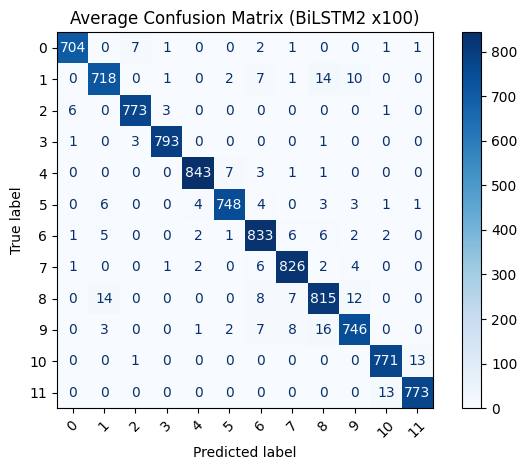

In [131]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 평균 및 표준편차 출력
print("📊 BiLSTM2 Accuracy : {:.4f} ± {:.4f}".format(np.mean(bilstm2_acc_list), np.std(bilstm2_acc_list)))
print("📊 BiLSTM2 Precision: {:.4f} ± {:.4f}".format(np.mean(bilstm2_prec_list), np.std(bilstm2_prec_list)))
print("📊 BiLSTM2 Recall   : {:.4f} ± {:.4f}".format(np.mean(bilstm2_recall_list), np.std(bilstm2_recall_list)))
print("📊 BiLSTM2 F1-score : {:.4f} ± {:.4f}".format(np.mean(bilstm2_f1_list), np.std(bilstm2_f1_list)))

# Confusion Matrix 시각화
bilstm2_cm_avg = bilstm2_cm_sum // 100
ConfusionMatrixDisplay(confusion_matrix=bilstm2_cm_avg).plot(cmap='Blues', xticks_rotation=45)
plt.title("Average Confusion Matrix (BiLSTM2 x100)")
plt.tight_layout()
plt.show()


### Bi-GRU

In [132]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

# 클래스 수
num_classes = 12

# 결과 저장 리스트 초기화
bigru2_acc_list = []
bigru2_prec_list = []
bigru2_recall_list = []
bigru2_f1_list = []
bigru2_cm_sum = np.zeros((num_classes, num_classes), dtype=int)

# EarlyStopping 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=0
)

# 🔁 BiGRU2 100회 반복 학습
for i in range(100):
    bigru2 = Sequential()
    bigru2.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_nogry_train.shape[1], X_nogry_train.shape[2])))
    bigru2.add(Dropout(0.3))
    bigru2.add(Bidirectional(GRU(64)))
    bigru2.add(Dropout(0.3))
    bigru2.add(Dense(32, activation='relu'))
    bigru2.add(Dense(num_classes, activation='softmax'))

    bigru2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    bigru2.fit(X_nogry_train, y_act_train,
               epochs=50,
               batch_size=64,
               validation_split=0.2,
               callbacks=[early_stop],
               verbose=0)

    y_pred_bigru2 = np.argmax(bigru2.predict(X_nogry_test, verbose=0), axis=1)

    bigru2_acc_list.append(accuracy_score(y_act_test, y_pred_bigru2))
    bigru2_prec_list.append(precision_score(y_act_test, y_pred_bigru2, average='macro', zero_division=0))
    bigru2_recall_list.append(recall_score(y_act_test, y_pred_bigru2, average='macro', zero_division=0))
    bigru2_f1_list.append(f1_score(y_act_test, y_pred_bigru2, average='macro', zero_division=0))

    bigru2_cm_sum += confusion_matrix(y_act_test, y_pred_bigru2)

print("✅ BiGRU2 모델 100회 학습 완료 (X_nogry 기반)")


✅ BiGRU2 모델 100회 학습 완료 (X_nogry 기반)


📊 BiGRU2 Accuracy : 0.9723 ± 0.0026
📊 BiGRU2 Precision: 0.9727 ± 0.0025
📊 BiGRU2 Recall   : 0.9722 ± 0.0026
📊 BiGRU2 F1-score : 0.9724 ± 0.0026


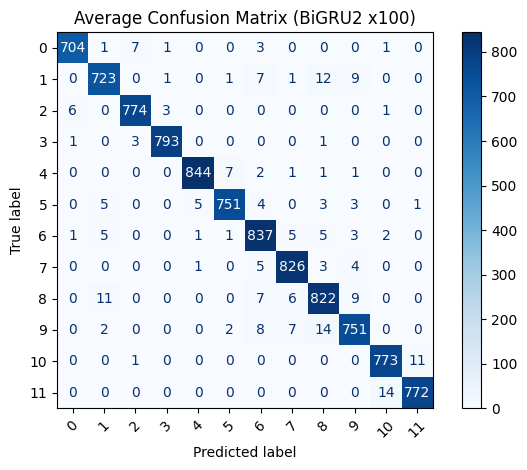

In [133]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

print("📊 BiGRU2 Accuracy : {:.4f} ± {:.4f}".format(np.mean(bigru2_acc_list), np.std(bigru2_acc_list)))
print("📊 BiGRU2 Precision: {:.4f} ± {:.4f}".format(np.mean(bigru2_prec_list), np.std(bigru2_prec_list)))
print("📊 BiGRU2 Recall   : {:.4f} ± {:.4f}".format(np.mean(bigru2_recall_list), np.std(bigru2_recall_list)))
print("📊 BiGRU2 F1-score : {:.4f} ± {:.4f}".format(np.mean(bigru2_f1_list), np.std(bigru2_f1_list)))

bigru2_cm_avg = bigru2_cm_sum // 100
ConfusionMatrixDisplay(confusion_matrix=bigru2_cm_avg).plot(cmap='Blues', xticks_rotation=45)
plt.title("Average Confusion Matrix (BiGRU2 x100)")
plt.tight_layout()
plt.show()


In [137]:
import pickle

# 예시용으로 lstm1만 넣었지만, 나머지 모델들도 똑같이 확장해서 넣으면 됩니다.
results = {
    'lstm1': {
        'accuracy': lstm1_acc_list,
        'precision': lstm1_prec_list,
        'recall': lstm1_recall_list,
        'f1_score': lstm1_f1_list,
        'confusion_matrix_sum': lstm1_cm_sum
    },
    'lstm2': {
        'accuracy': lstm2_acc_list,
        'precision': lstm2_prec_list,
        'recall': lstm2_recall_list,
        'f1_score': lstm2_f1_list,
        'confusion_matrix_sum': lstm2_cm_sum
    },
    'gru1': {
        'accuracy': gru1_acc_list,
        'precision': gru1_prec_list,
        'recall': gru1_recall_list,
        'f1_score': gru1_f1_list,
        'confusion_matrix_sum': gru1_cm_sum
    },
    'gru2': {
        'accuracy': gru2_acc_list,
        'precision': gru2_prec_list,
        'recall': gru2_recall_list,
        'f1_score': gru2_f1_list,
        'confusion_matrix_sum': gru2_cm_sum
    },
    'bilstm1': {
        'accuracy': bilstm1_acc_list,
        'precision': bilstm1_prec_list,
        'recall': bilstm1_recall_list,
        'f1_score': bilstm1_f1_list,
        'confusion_matrix_sum': bilstm1_cm_sum
    },
    'bilstm2': {
        'accuracy': bilstm2_acc_list,
        'precision': bilstm2_prec_list,
        'recall': bilstm2_recall_list,
        'f1_score': bilstm2_f1_list,
        'confusion_matrix_sum': bilstm2_cm_sum
    },
    'bigru1': {
        'accuracy': bigru1_acc_list,
        'precision': bigru1_prec_list,
        'recall': bigru1_recall_list,
        'f1_score': bigru1_f1_list,
        'confusion_matrix_sum': bigru1_cm_sum
    },
    'bigru2': {
        'accuracy': bigru2_acc_list,
        'precision': bigru2_prec_list,
        'recall': bigru2_recall_list,
        'f1_score': bigru2_f1_list,
        'confusion_matrix_sum': bigru2_cm_sum
    },
}

# 파일로 저장
with open('model_metrics_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("✅ 모든 모델 결과가 model_metrics_results.pkl 파일에 저장되었습니다.")

✅ 모든 모델 결과가 model_metrics_results.pkl 파일에 저장되었습니다.


In [142]:
with open('model_metrics_results.pkl', 'rb') as f:
    results = pickle.load(f)

# 예시: lstm1의 평균 accuracy 확인
print("LSTM1 평균 정확도:", len(results['lstm2']['confusion_matrix_sum']))

LSTM1 평균 정확도: 12
